# Anggota Kelompok
1. Muhammad Rayhan Nuansa Adha (2006571053)
2. Peksyaji (2006522322)
3. Nadia Sukesi Sianipar (2106700776)

# IMPORT DATASET

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'rocoleoriginal:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1293723%2F2155408%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240608%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240608T035215Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D98c64d37eaa304b1f79af00385c10428bf7bce4013792708c6445c51494068794ea22e4997d642f3028e6832a57dc495769ff033c4dbfcbb9c689d9a3f7a8cfb4e79c8f5d254836b1b4a6f4d40d35422c03a9a25294c96d4d7315c430432db5299bc9388ef18afac4e4ad18c7b40c728242d965146d77e7f471a76e762fe9786a734569b398fd1d45fbaea3fd9d804bcb4334835dee22335c48512d03c51df17fa500550a71f84645ac7ec401b6c6307038d7d1e8fce99ec663a72c04852cbe27f9524d33b7758eb2c823e0e5b062ea38ca5eaa49da6e149900e6e7afba3043a2b6d25fbec9801baf0b303c3927f137b8cbdad79e5399b7509652ee23daae98c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2245876456 bytes downloaded
Downloaded and uncompressed: rocoleoriginal
Data source import complete.


# Analisis Perbandingan Arsitektur Convolutional Neural Network (CNN) untuk Deteksi Karat Pada Daun Tanaman Kopi


# 1. Imports library

In [ ]:
!pip install xlrd>=1.3.0
!pip install openpyxl

In [ ]:
try:
    %tensorflow_version 2.x

except Exception:
    pass

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Flatten
from sklearn.metrics import classification_report
import tensorflow_datasets as tfds
import tensorflow_hub as hub

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib

import itertools

print('Tensorflow version : {}'.format(tf.__version__))

tf.keras.backend.clear_session()
tf.executing_eagerly()==True

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version : 2.15.0


True

# 2. Pemilihan Strategi

## 2.1. Pendeteksian CPU atau GPU

Berdasarkan hardware yang tersedia, strategi distribusi yang digunakan akan berbeda.

- Jika GPU yang tersedia lebih dari satu, maka akan digunakan strategi mirrored.
- Jika hanya ada satu GPU yang tersedia atau jika hanya CPU yang tersedia, maka akan digunakan strategi default.

In [ ]:
# Pendeteksian hardware
try:
    gpus = tf.config.experimental.list_logical_devices("GPU")
except ValueError:
    gpu = 0

# Pemilihan strategi distribusi yang sesuai
if len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on single GPU ', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


# 3. Parameter Global

Nilai variabel BATCH_SIZE global dalam strategi distribusi merupakan hasil perkalian antara ukuran batch per replika dengan jumlah replika dalam strategi distribusi.

In [ ]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync

In [ ]:
IMAGE_SIZE=224
CLASS_NAMES=[]
IMG_COUNT=0
num_classes=0

MAIN_IMG_DIR = '../input/rocoleoriginal/Photos'
MAIN_ANN_DIR = '../input/rocoleoriginal/Annotations'

# 4. Muat dan Preprocessing Dataset

## 4.1. Explore data

In [ ]:
data_dir = pathlib.Path(MAIN_IMG_DIR)
print("Directory:", data_dir)
IMG_COUNT = len(list(data_dir.glob('*.jpg')))
print("Number of images:",IMG_COUNT)

Directory: ../input/rocoleoriginal/Photos
Number of images: 1560


In [ ]:
df = pd.read_excel(MAIN_ANN_DIR+'/RoCoLe-classes.xlsx',engine='openpyxl')
df.head()

,File,Binary.Label,Multiclass.Label
0,C1P1H1.jpg,healthy,healthy
1,C1P2E2.jpg,unhealthy,rust_level_2
2,C1P2H1.jpg,healthy,healthy
3,C1P3E1.jpg,healthy,healthy
4,C1P3E2.jpg,unhealthy,rust_level_2


In [ ]:
df.drop(['Multiclass.Label'], axis=1, inplace=True)
df.rename(columns={'Binary.Label':'Label'},inplace=True)

In [ ]:
num_classes=df.drop_duplicates(subset = ["Label"]).count()["Label"]
print("Number of Labels(in Binary.Label  column): "+ str(num_classes))
df.drop_duplicates(subset = ["Label"])

check_imbalance = df.pivot_table(index=['Label'], aggfunc='size')
print (check_imbalance)

Number of Labels(in Binary.Label  column): 2
Label
healthy      791
unhealthy    769
dtype: int64


In [ ]:
CLASS_NAMES = (pd.Series.to_string(df.drop_duplicates(subset = ["Label"])["Label"],index=False).strip()).split()
CLASS_NAMES.sort()
print(CLASS_NAMES)

['healthy', 'unhealthy']


In [ ]:
dictOfWords = { CLASS_NAMES[i]:i for i in range(0, len(CLASS_NAMES))}
dictOfWords

{'healthy': 0, 'unhealthy': 1}

In [ ]:
df["Label"] = df["Label"].map(dictOfWords)
df

,File,Label
0,C1P1H1.jpg,0
1,C1P2E2.jpg,1
2,C1P2H1.jpg,0
3,C1P3E1.jpg,0
4,C1P3E2.jpg,1
...,...,...
1555,C12P40E2.jpg,1
1556,C12P40H1.jpg,0
1557,C12P40H2.jpg,1
1558,C8P24E2.jpg,1


## 4.2. Pre-processing Data

### 4.2.1 Pembagian Dataset

Akan dibuat 2 dataset:

* train_ds = training set, 80%.
* val_ds = validation set, 20%.

In [ ]:
target = df.pop('Label')
dir_img=MAIN_IMG_DIR+'/{}'
df=df.applymap(dir_img.format)


dataset = tf.data.Dataset.from_tensor_slices((df.values, target.values))
dataset = dataset.shuffle(IMG_COUNT, reshuffle_each_iteration=False)

val_size = int(IMG_COUNT * 0.20)
train_ds = dataset.skip(val_size)
val_ds = dataset.take(int(val_size))


train_size=tf.data.experimental.cardinality(train_ds).numpy()
val_size=tf.data.experimental.cardinality(val_ds).numpy()

print("Training size: {}".format(train_size))
print("Validation size: {}".format(val_size))
print("Total images: ",train_size+val_size)
print("\nExample: ")
for feat, targ in train_ds.take(5):
    print ('Image: {}, Label: {}'.format(feat, targ))

Training size: 1248
Validation size: 312
Total images:  1560

Example: 
Image: [b'../input/rocoleoriginal/Photos/C4P25H2.jpg'], Label: 1
Image: [b'../input/rocoleoriginal/Photos/C7P18H1.jpg'], Label: 1
Image: [b'../input/rocoleoriginal/Photos/C12P9H1.jpg'], Label: 0
Image: [b'../input/rocoleoriginal/Photos/C11P27H2.jpg'], Label: 0
Image: [b'../input/rocoleoriginal/Photos/C1P2E1.jpg'], Label: 0


In [ ]:
'''
Transforms each image in dataset
'''

def parse_image(feat, targ):

    image = tf.io.read_file(feat[0])
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)

    # image pretreatment
    image = tf.image.resize(image, [1512, 1512])
    image =  tf.image.central_crop(image, central_fraction=0.65)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])

    label= tf.cast(targ,tf.int32)

    return image, label
'''
Loads and maps the training split of the dataset using the map function.
'''
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_training_dataset():

      with  strategy.scope():
        dataset = train_ds.map(parse_image, num_parallel_calls=16)
        dataset = dataset.shuffle(buffer_size=train_size,
                                  reshuffle_each_iteration=True)
        dataset = dataset.repeat()
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        dataset = dataset.prefetch(AUTOTUNE)
        return dataset

'''
Loads and maps the validation split of the dataset using the map function.
'''
def get_validation_dataset():

    dataset = val_ds.map(parse_image, num_parallel_calls=16)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.shuffle(buffer_size=train_size,
                              reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

# instantiate the datasets
with strategy.scope():
    training_dataset = get_training_dataset()
    validation_dataset = get_validation_dataset()

### 4.2.2. Visualisasi

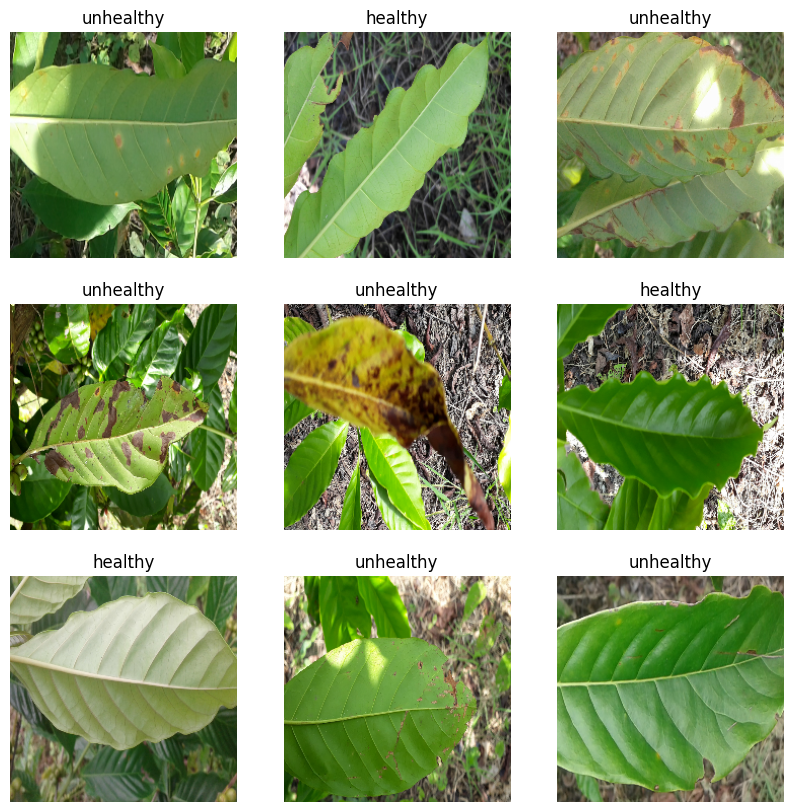

In [ ]:
image_batch, label_batch = next(iter(training_dataset))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    ax.set_axis_off()
    plt.imshow(image_batch[i])
    label = label_batch[i]
    #index = tf.argmax(label.numpy(), axis=0)
    plt.title(CLASS_NAMES[label])


# 5. Pembentukan Model

## 5.1. Variabel

In [ ]:
# Variabel training
EPOCHS = 100
steps_per_epoch = (train_size)//BATCH_SIZE
validation_steps = (val_size)//BATCH_SIZE
IMG_DIM=(IMAGE_SIZE,IMAGE_SIZE)

In [ ]:
# Fungsi Callback
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20,
                                                  restore_best_weights=True)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
# Plot akurasi dari Training dan Validation
def plot_history(hist,Text):
  history=hist
  acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  epochs_range = range(len(history.epoch))

  plt.figure(figsize=(12,8))
  plt.subplot(1,2,1)
  plt.plot(epochs_range,acc,label="Train Accuracy")
  plt.plot(epochs_range,val_acc,label="Validation Accuracy")
  plt.legend(loc = 'lower right')
  plt.title("Accuracy")
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label="Train Loss")
  plt.plot(epochs_range,val_loss,label="Validation Loss")
  plt.legend(loc = 'upper right')
  plt.title("Loss")
  plt.suptitle(Text)

## 5.2. ResNet101V2

### 5.2.1. Definisikan model

In [ ]:
IMG_DIM=(IMAGE_SIZE,IMAGE_SIZE)
def make_model():
    data_augmentation = tf.keras.Sequential([
    tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),  # 224x224x3
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(IMAGE_SIZE,
                                                              IMAGE_SIZE,
                                                              3)),
     tf.keras.layers.experimental.preprocessing.RandomFlip("vertical",
                                                 input_shape=(IMAGE_SIZE,
                                                              IMAGE_SIZE,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.5),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.80)
    ])

    base_model = tf.keras.applications.ResNet101V2(input_shape=(*IMG_DIM, 3),
                                             include_top=False,
                                             weights= 'imagenet')
    base_model.trainable = False

    model = tf.keras.Sequential([
        data_augmentation,
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation="relu"),
         tf.keras.layers.Dropout(0.4),
         tf.keras.layers.Dense(512, activation="relu" ),
         tf.keras.layers.Dropout(0.4),
         tf.keras.layers.BatchNormalization(),
         tf.keras.layers.Dense(num_classes-1,activation="sigmoid")
])

    return model

### 5.2.2. Compile model

In [ ]:
with strategy.scope():
    model = make_model()
    model.compile(loss="binary_crossentropy",
    optimizer='adam',
    metrics=["accuracy"])

171317808/171317808 [==============================] - 4s 0us/step


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)              

### 5.2.3. Train model

In [ ]:
checkpoint1 = tf.keras.callbacks.ModelCheckpoint("RN101v2.h5", save_best_only=True, save_format='h5')

history1 = model.fit(training_dataset,steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data = validation_dataset, validation_steps=validation_steps,
                    batch_size=BATCH_SIZE,
                     callbacks=[checkpoint1, early_stopping,lr_scheduler])

Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 0.7518 - accuracy: 0.6028

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 236s 8s/step - loss: 0.7518 - accuracy: 0.6028 - val_loss: 1.1636 - val_accuracy: 0.6016 - lr: 0.0100
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6327 - accuracy: 0.6488

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 178s 10s/step - loss: 0.6327 - accuracy: 0.6488 - val_loss: 0.5125 - val_accuracy: 0.8125 - lr: 0.0089
Epoch 3/100
19/19 [==============================] - 116s 6s/step - loss: 0.5813 - accuracy: 0.6982 - val_loss: 0.6709 - val_accuracy: 0.6875 - lr: 0.0079
Epoch 4/100
19/19 [==============================] - ETA: 0s - loss: 0.5553 - accuracy: 0.7253

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 153s 8s/step - loss: 0.5553 - accuracy: 0.7253 - val_loss: 0.4546 - val_accuracy: 0.7969 - lr: 0.0071
Epoch 5/100
19/19 [==============================] - ETA: 0s - loss: 0.5079 - accuracy: 0.7475

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 181s 10s/step - loss: 0.5079 - accuracy: 0.7475 - val_loss: 0.4285 - val_accuracy: 0.7930 - lr: 0.0063
Epoch 6/100
19/19 [==============================] - ETA: 0s - loss: 0.4811 - accuracy: 0.7738

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 169s 9s/step - loss: 0.4811 - accuracy: 0.7738 - val_loss: 0.3678 - val_accuracy: 0.8477 - lr: 0.0056
Epoch 7/100
19/19 [==============================] - ETA: 0s - loss: 0.5060 - accuracy: 0.7706

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 146s 8s/step - loss: 0.5060 - accuracy: 0.7706 - val_loss: 0.3453 - val_accuracy: 0.8516 - lr: 0.0050
Epoch 8/100
19/19 [==============================] - 112s 6s/step - loss: 0.4687 - accuracy: 0.7763 - val_loss: 0.3770 - val_accuracy: 0.8320 - lr: 0.0045
Epoch 9/100
19/19 [==============================] - 116s 6s/step - loss: 0.4727 - accuracy: 0.7796 - val_loss: 0.4462 - val_accuracy: 0.7969 - lr: 0.0040
Epoch 10/100
19/19 [==============================] - 112s 6s/step - loss: 0.4724 - accuracy: 0.7697 - val_loss: 0.3610 - val_accuracy: 0.8203 - lr: 0.0035
Epoch 11/100
19/19 [==============================] - 137s 8s/step - loss: 0.4673 - accuracy: 0.7845 - val_loss: 0.3503 - val_accuracy: 0.8320 - lr: 0.0032
Epoch 12/100
19/19 [==============================] - 112s 6s/step - loss: 0.4406 - accuracy: 0.7928 - val_loss: 0.4567 - val_accuracy: 0.7773 - lr: 0.0028
Epoch 13/100
19/19 [==============================] - 106s 6s/step - loss: 0.42

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 183s 10s/step - loss: 0.4074 - accuracy: 0.8125 - val_loss: 0.3402 - val_accuracy: 0.8516 - lr: 0.0020
Epoch 16/100
19/19 [==============================] - 131s 7s/step - loss: 0.4227 - accuracy: 0.8076 - val_loss: 0.3416 - val_accuracy: 0.8516 - lr: 0.0018
Epoch 17/100
19/19 [==============================] - 131s 7s/step - loss: 0.4135 - accuracy: 0.8174 - val_loss: 0.3661 - val_accuracy: 0.8320 - lr: 0.0016
Epoch 18/100
19/19 [==============================] - 130s 7s/step - loss: 0.4123 - accuracy: 0.8117 - val_loss: 0.3719 - val_accuracy: 0.8320 - lr: 0.0014
Epoch 19/100
19/19 [==============================] - 133s 7s/step - loss: 0.4153 - accuracy: 0.8059 - val_loss: 0.3460 - val_accuracy: 0.8555 - lr: 0.0013
Epoch 20/100
19/19 [==============================] - 105s 6s/step - loss: 0.4152 - accuracy: 0.8158 - val_loss: 0.3835 - val_accuracy: 0.8320 - lr: 0.0011
Epoch 21/100
19/19 [==============================] - 131s 7s/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 193s 11s/step - loss: 0.3933 - accuracy: 0.8257 - val_loss: 0.3397 - val_accuracy: 0.8633 - lr: 5.0119e-04
Epoch 28/100
19/19 [==============================] - 136s 8s/step - loss: 0.4142 - accuracy: 0.8133 - val_loss: 0.3403 - val_accuracy: 0.8672 - lr: 4.4668e-04
Epoch 29/100
19/19 [==============================] - 138s 8s/step - loss: 0.3727 - accuracy: 0.8265 - val_loss: 0.3460 - val_accuracy: 0.8594 - lr: 3.9811e-04
Epoch 30/100
19/19 [==============================] - 115s 6s/step - loss: 0.4113 - accuracy: 0.8117 - val_loss: 0.3568 - val_accuracy: 0.8398 - lr: 3.5481e-04
Epoch 31/100
19/19 [==============================] - 136s 8s/step - loss: 0.3977 - accuracy: 0.8224 - val_loss: 0.3545 - val_accuracy: 0.8516 - lr: 3.1623e-04
Epoch 32/100
19/19 [==============================] - 113s 6s/step - loss: 0.4225 - accuracy: 0.7977 - val_loss: 0.3533 - val_accuracy: 0.8516 - lr: 2.8184e-04
Epoch 33/100
19/19 [==============================] 

### 5.2.4. Plot hasil model

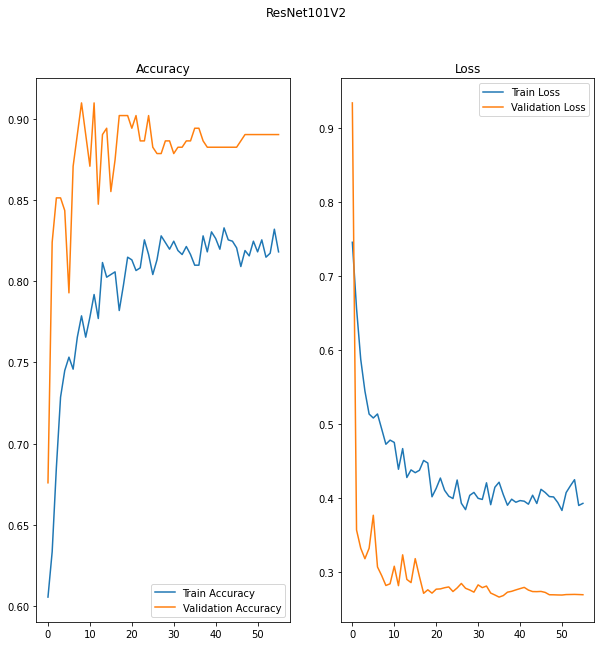

In [ ]:
# Plotting Training and Validation Accuracy
plot_history(history1,"ResNet101V2")

### 5.2.5. Evaluasi model

In [ ]:
#Memuat model terbaik yang disimpan
best_model1 = tf.keras.models.load_model("RN101v2.h5", compile=True)

# Evaluasi model menggunakan data validasi atau test
evaluation1 = best_model1.evaluate(validation_dataset, steps=validation_steps)

# Menampilkan hasil evaluasi
print(f"Loss: {evaluation1[0]}, Accuracy: {evaluation1[1]}")

4/4 [==============================] - 37s 2s/step - loss: 0.2657 - accuracy: 0.8945
Loss: 0.2657374441623688, Accuracy: 0.89453125


In [ ]:
# Prediksi label pada dataset validasi atau test
y_true1 = []
y_pred1 = []

for images, labels in validation_dataset.take(validation_steps):
    y_true1.extend(labels.numpy())
    y_pred1.extend(best_model1.predict(images))

# Binarize y_pred
y_pred1 = (np.array(y_pred1) > 0.5).astype(int)

# Menghitung metrik evaluasi tambahan
print(classification_report(y_true1, y_pred1, target_names=[str(i) for i in range(num_classes)]))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       124
           1       0.88      0.92      0.90       132

    accuracy                           0.89       256
   macro avg       0.90      0.89      0.89       256
weighted avg       0.90      0.89      0.89       256



## 5.3. MobileNetV2

### 5.3.1. Definisikan model

In [ ]:

def make_model():
    data_augmentation = tf.keras.Sequential([
    tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),  # 128x128x3
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(IMAGE_SIZE,
                                                              IMAGE_SIZE,
                                                              3)),
     tf.keras.layers.experimental.preprocessing.RandomFlip("vertical",
                                                 input_shape=(IMAGE_SIZE,
                                                              IMAGE_SIZE,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.5),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.80)
    ])

    base_model = tf.keras.applications.MobileNetV2(input_shape=(*IMG_DIM, 3),
                                             include_top=False,
                                             weights= 'imagenet')
    base_model.trainable = False

    model = tf.keras.Sequential([
        data_augmentation,
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation="relu"),
         tf.keras.layers.Dropout(0.4),
         tf.keras.layers.Dense(512, activation="relu" ),
         tf.keras.layers.Dropout(0.4),
         tf.keras.layers.BatchNormalization(),
         tf.keras.layers.Dense(num_classes-1,activation="sigmoid")
])

    return model

### 5.3.2. Compile model

In [ ]:
with strategy.scope():
    model2 = make_model()
    model2.compile(loss="binary_crossentropy",
    optimizer='adam',
    metrics=["accuracy"])

9412608/9406464 [==============================] - 1s 0us/step


In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              64226304  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)              

### 5.3.3. Train model

In [ ]:
checkpoint2 = tf.keras.callbacks.ModelCheckpoint("MNetV2.h5",
                                                save_best_only=True, save_format='h5')
history2 = model2.fit(training_dataset,steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data = validation_dataset, validation_steps=validation_steps,
                    batch_size=BATCH_SIZE,
                     callbacks=[checkpoint2, early_stopping,lr_scheduler])

Epoch 1/100
19/19 [==============================] - 112s 4s/step - loss: 0.8025 - accuracy: 0.5911 - val_loss: 0.6381 - val_accuracy: 0.6641
Epoch 2/100
19/19 [==============================] - 76s 4s/step - loss: 0.6421 - accuracy: 0.6478 - val_loss: 0.4849 - val_accuracy: 0.7852
Epoch 3/100
19/19 [==============================] - 78s 4s/step - loss: 0.5739 - accuracy: 0.6936 - val_loss: 0.4194 - val_accuracy: 0.7891
Epoch 4/100
19/19 [==============================] - 78s 4s/step - loss: 0.5109 - accuracy: 0.7363 - val_loss: 0.3682 - val_accuracy: 0.8633
Epoch 5/100
19/19 [==============================] - 76s 4s/step - loss: 0.4937 - accuracy: 0.7677 - val_loss: 0.3853 - val_accuracy: 0.8359
Epoch 6/100
19/19 [==============================] - 74s 4s/step - loss: 0.4707 - accuracy: 0.7860 - val_loss: 0.3605 - val_accuracy: 0.8516
Epoch 7/100
19/19 [==============================] - 69s 4s/step - loss: 0.4866 - accuracy: 0.7905 - val_loss: 0.4216 - val_accuracy: 0.7969
Epoch 8/100


### 5.3.4. Plot hasil model

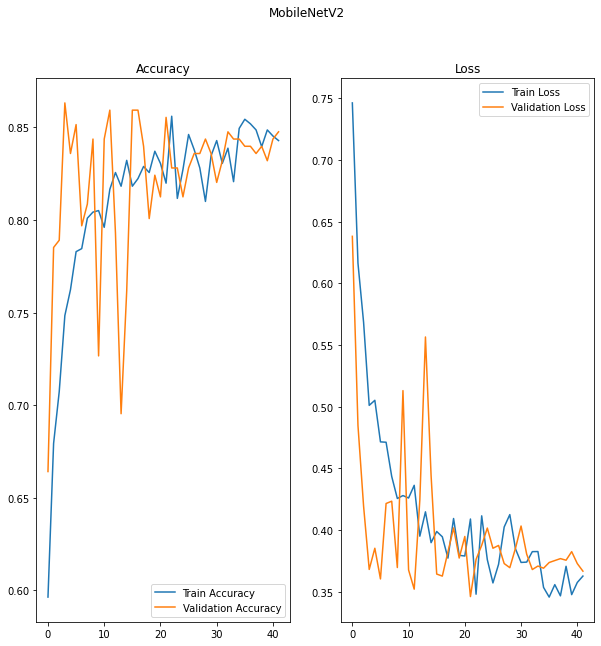

In [ ]:
# Plotting Training and Validation Accuracy
plot_history(history2,"MobileNetV2")

### 5.3.5. Evaluasi model

In [ ]:
#Memuat model terbaik yang disimpan
best_model2 = tf.keras.models.load_model("MNetV2.h5", compile=True)

# Evaluasi model menggunakan data validasi atau test
evaluation2 = best_model2.evaluate(validation_dataset, steps=validation_steps)

# Menampilkan hasil evaluasi
print(f"Loss: {evaluation2[0]}, Accuracy: {evaluation2[1]}")

4/4 [==============================] - 36s 2s/step - loss: 0.3462 - accuracy: 0.8555
Loss: 0.346177339553833, Accuracy: 0.85546875


In [ ]:
# Prediksi label pada dataset validasi atau test
y_true2 = []
y_pred2 = []

for images, labels in validation_dataset.take(validation_steps):
    y_true2.extend(labels.numpy())
    y_pred2.extend(best_model2.predict(images))

# Binarize y_pred
y_pred2 = (np.array(y_pred2) > 0.5).astype(int)

# Menghitung metrik evaluasi tambahan
print(classification_report(y_true2, y_pred2, target_names=[str(i) for i in range(num_classes)]))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84       124
           1       0.83      0.91      0.87       132

    accuracy                           0.86       256
   macro avg       0.86      0.85      0.85       256
weighted avg       0.86      0.86      0.85       256



## 5.4. DenseNet121

### 5.4.1. Definisikan model

In [ ]:
def make_model():
    data_augmentation = tf.keras.Sequential([
    tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),  # 128x128x3
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(IMAGE_SIZE,
                                                              IMAGE_SIZE,
                                                              3)),
     tf.keras.layers.experimental.preprocessing.RandomFlip("vertical",
                                                 input_shape=(IMAGE_SIZE,
                                                              IMAGE_SIZE,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.5),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.80)
    ])

    base_model = tf.keras.applications.DenseNet121(input_shape=(*IMG_DIM, 3),
                                                   include_top=False,
                                                   weights='imagenet')
    base_model.trainable = False

    model = tf.keras.Sequential([
        data_augmentation,
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation="relu"),
         tf.keras.layers.Dropout(0.4),
         tf.keras.layers.Dense(512, activation="relu" ),
         tf.keras.layers.Dropout(0.4),
         tf.keras.layers.BatchNormalization(),
         tf.keras.layers.Dense(num_classes-1,activation="sigmoid")
])

    return model

### 5.4.2. Compile model

In [ ]:
with strategy.scope():
    model3 = make_model()
    model3.compile(loss="binary_crossentropy",
    optimizer='adam',
    metrics=["accuracy"])

29089792/29084464 [==============================] - 2s 0us/step


In [ ]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              51381248  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

### 5.4.3. Train model

In [ ]:
checkpoint3 = tf.keras.callbacks.ModelCheckpoint("DenseNet121.h5",
                                                save_best_only=True, save_format='h5')
history3 = model3.fit(training_dataset,steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data = validation_dataset, validation_steps=validation_steps,
                    batch_size=BATCH_SIZE,
                     callbacks=[checkpoint3, early_stopping,lr_scheduler])

Epoch 1/100
19/19 [==============================] - 118s 4s/step - loss: 0.8498 - accuracy: 0.5571 - val_loss: 0.4888 - val_accuracy: 0.7109
Epoch 2/100
19/19 [==============================] - 77s 4s/step - loss: 0.7049 - accuracy: 0.5828 - val_loss: 0.4271 - val_accuracy: 0.8281
Epoch 3/100
19/19 [==============================] - 80s 4s/step - loss: 0.6525 - accuracy: 0.6588 - val_loss: 0.4134 - val_accuracy: 0.8242
Epoch 4/100
19/19 [==============================] - 81s 4s/step - loss: 0.5622 - accuracy: 0.7172 - val_loss: 0.3506 - val_accuracy: 0.8438
Epoch 5/100
19/19 [==============================] - 70s 4s/step - loss: 0.4924 - accuracy: 0.7446 - val_loss: 0.2970 - val_accuracy: 0.8633
Epoch 6/100
19/19 [==============================] - 73s 4s/step - loss: 0.4590 - accuracy: 0.7949 - val_loss: 0.2878 - val_accuracy: 0.8711
Epoch 7/100
19/19 [==============================] - 74s 4s/step - loss: 0.5034 - accuracy: 0.7560 - val_loss: 0.3372 - val_accuracy: 0.8633
Epoch 8/100


#### 5.4.4. Plot hasil model

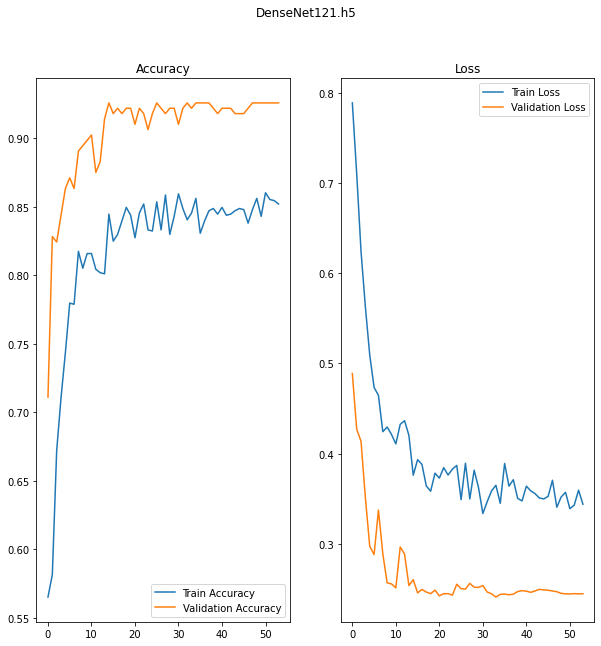

In [ ]:
# Plotting Training and Validation Accuracy
plot_history(history3,"DenseNet121.h5")

### 5.4.5. Evaluasi model

In [ ]:
#Memuat model terbaik yang disimpan
best_model3 = tf.keras.models.load_model("DenseNet121.h5", compile=True)

# Evaluasi model menggunakan data validasi atau test
evaluation3 = best_model3.evaluate(validation_dataset, steps=validation_steps)

# Menampilkan hasil evaluasi
print(f"Loss: {evaluation3[0]}, Accuracy: {evaluation3[1]}")

4/4 [==============================] - 38s 1s/step - loss: 0.2405 - accuracy: 0.9219
Loss: 0.24052101373672485, Accuracy: 0.921875


In [ ]:
# Prediksi label pada dataset validasi atau test
y_true3 = []
y_pred3 = []

for images, labels in validation_dataset.take(validation_steps):
    y_true3.extend(labels.numpy())
    y_pred3.extend(best_model3.predict(images))

# Binarize y_pred
y_pred3 = (np.array(y_pred3) > 0.5).astype(int)

# Menghitung metrik evaluasi tambahan
print(classification_report(y_true3, y_pred3, target_names=[str(i) for i in range(num_classes)]))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       124
           1       0.94      0.91      0.92       132

    accuracy                           0.92       256
   macro avg       0.92      0.92      0.92       256
weighted avg       0.92      0.92      0.92       256

